### デバッグ用

In [1]:
import sys, os
sys.path.insert(0, os.path.join(os.getcwd(), '..'))

### モジュールインポート

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
from sklearn.datasets import load_boston
from sklearn import model_selection as ms
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import kennard_stone as ks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from boruta import BorutaPy
import seaborn as sns

### 定数等

In [3]:
SEED = 334
np.random.seed(SEED)
rf = RandomForestRegressor(n_estimators = 100, random_state = SEED, n_jobs = -1)

### サンプルデータ

In [4]:
boston = load_boston()
X = pd.DataFrame(boston['data'], columns = boston['feature_names'])
y = pd.Series(boston['target'], name = 'PRICE')
display(X.head(), y.head())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
Name: PRICE, dtype: float64

## train_test_split
KennardStoneの有効性が出やすい．

### sklearnのtrain_test_split
ランダム要素が強いので1000回やってみる

In [5]:
max_iter = 1000

In [6]:
scores = {
    'MSE':[],
    'R2':[]
}
for _iter in tqdm(range(max_iter)):
    X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size = 0.2, random_state = np.random.randint(0, 2 ** 32))
    rf.fit(X_train, y_train)
    y_pred_on_test = rf.predict(X_test)
    scores['MSE'].append(mse(y_test, y_pred_on_test))
    scores['R2'].append(r2_score(y_test, y_pred_on_test))

100%|██████████| 1000/1000 [01:44<00:00,  9.55it/s]


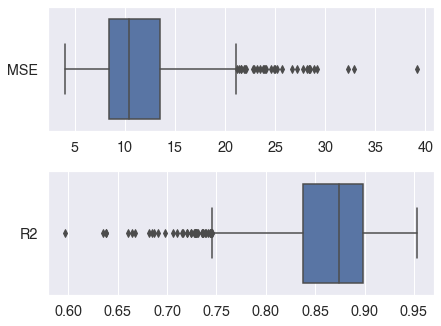

In [7]:
sns.set(style = 'darkgrid', font = 'Helvetica', font_scale = 1.3)
fig = plt.figure(facecolor = 'white', figsize = (6.4, 4.8))
for i, score_name in enumerate(scores):
    ax = fig.add_subplot(2, 1, i+1)
    sns.boxplot(ax = ax, data = pd.DataFrame(scores[score_name], columns = [score_name]), orient = 'h')
plt.tight_layout()

In [8]:
sns.reset_defaults()

#### 平均

In [9]:
for score_name, v in scores.items():
    print('{0}: {1:.3f}'.format(score_name, np.average(v)))

MSE: 11.450
R2: 0.862


### kennard stone

In [10]:
X_train, X_test, y_train, y_test = ks.train_test_split(X, y, test_size = 0.2)

In [11]:
rf = clone(rf)
rf.fit(X_train, y_train)
y_pred_on_test = rf.predict(X_test)

In [12]:
print('MSE: {:.3f}'.format(mse(y_test, y_pred_on_test)))
print('R2: {:.3f}'.format(r2_score(y_test, y_pred_on_test)))

MSE: 4.856
R2: 0.932


## cross_val_score
cross_validationでは差が出にくい．

In [13]:
n_splits = 5
rf = clone(rf)

### sklearn

In [14]:
scores = {
    'MSE':[],
    'R2':[]
}
for i in tqdm(range(max_iter)):
    kf = ms.KFold(n_splits = 5, random_state = np.random.randint(0, 2**32), shuffle = True)
    cv = ms.cross_validate(rf, X, y, cv = kf, scoring = ('neg_mean_squared_error', 'r2'))
    scores['MSE'].append(cv['test_neg_mean_squared_error'].mean() * -1)
    scores['R2'].append(cv['test_r2'].mean())

100%|██████████| 1000/1000 [07:14<00:00,  2.30it/s]


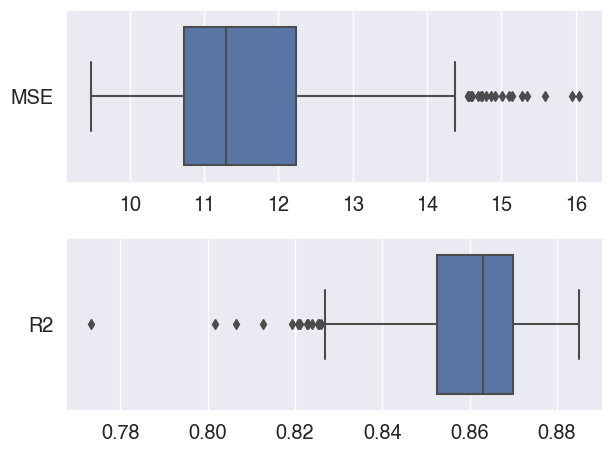

In [15]:
sns.set(style = 'darkgrid', font = 'Helvetica', font_scale = 1.3)
fig = plt.figure(facecolor = 'white', figsize = (6.4, 4.8))
for i, score_name in enumerate(scores):
    ax = fig.add_subplot(2, 1, i+1)
    sns.boxplot(ax = ax, data = pd.DataFrame(scores[score_name], columns = [score_name]), orient = 'h')
plt.tight_layout()

In [16]:
sns.reset_defaults()

In [17]:
for score_name, v in scores.items():
    print('{0}: {1:.3f}'.format(score_name, np.average(v)))

MSE: 11.569
R2: 0.860


### Kennard Stone

In [18]:
kf = ks.KFold(n_splits = 5)
cv = ms.cross_validate(rf, X, y, cv = kf, scoring = ('neg_mean_squared_error', 'r2'))
print('MSE: {:.3f}'.format(- cv['test_neg_mean_squared_error'].mean()))
print('R2: {:.3f}'.format(cv['test_r2'].mean()))

MSE: 10.895
R2: 0.881
